In [4]:
using DrWatson
@quickactivate "TriangularHubbard"

using TriangularHubbard
using PyPlot
using JSON
using LinearAlgebra

using DBInterface
using SQLite
using DataFrames

using PyCall
mpl = pyimport("matplotlib")

In [204]:
# shape_str = "(2,-2)x(2,4)"
shape_str = "(3,0)x(0,3)"

"(3,0)x(0,3)"

In [205]:
jsondata = open(datadir("lattice-$shape_str.json"), "r") do f
    JSON.parse(read(f, String))
end

Dict{String, Any} with 7 entries:
  "shape"                 => Any[Any[3, 0], Any[0, 3]]
  "momentums"             => Any[Dict{String, Any}("fractional_coordinates"=>An…
  "point_group_symmetry"  => "6mm"
  "supercell"             => Dict{String, Any}("sites"=>Any[Dict{String, Any}("…
  "equivalent_site_pairs" => Any[Any[Any[1, 1], Any[2, 2], Any[3, 3], Any[4, 4]…
  "unitcell"              => Dict{String, Any}("sites"=>Any[Dict{String, Any}("…
  "bravais_coordinates"   => Any[Any[0, 0], Any[1, 0], Any[2, 0], Any[0, 1], An…

In [206]:
shape = hcat(jsondata["shape"]...)
n_sites = Int(det(shape))
bravaiscoordinates = hcat(jsondata["bravais_coordinates"]...)
reciprocallatticevectors = hcat(jsondata["unitcell"]["reciprocallatticevectors"]...)
sitecoordinates = hcat((x["cartesian_coordinates"] for x in jsondata["supercell"]["sites"])...)
momentums = hcat((x["cartesian_coordinates"] for x in jsondata["momentums"])...)
fractionalmomentums = hcat(([eval(Meta.parse(y)) for y in x["fractional_coordinates"]] for x in jsondata["momentums"])...)
sitegroupmap = Dict()
for (i, vs) in enumerate(jsondata["equivalent_site_pairs"])
    for v in vs
        sitegroupmap[v] = i
    end
end


In [207]:
function getrealspacemap(data::AbstractVector)
    realspacemap = fill(NaN, n_sites)
    for i in 1:n_sites
        realspacemap[i] = data[sitegroupmap[[1,i]]]
    end
    return realspacemap
end
        

getrealspacemap (generic function with 1 method)

In [208]:
phases = cis.(-2π * momentums' * sitecoordinates)
# phases2 = cis.(-2π * fractionalmomentums' * bravaiscoordinates)
;

In [209]:
# realspacemap_test = rand(Float64, (n_sites, 1))
realspacemap_test = ones(Float64, (n_sites, 1))

9×1 Matrix{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [210]:
abs2.(phases * realspacemap_test)

9×1 Matrix{Float64}:
 81.0
  4.782469237902384e-30
  1.8797076257219422e-29
  8.874685183736383e-31
  2.0954117794933126e-31
  2.297557386456197e-29
  4.992010415851715e-30
  1.1093356479670479e-29
  1.232595164407831e-30

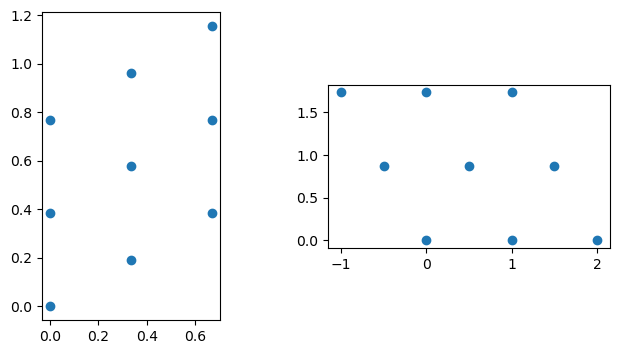

In [211]:
fig = PyPlot.figure(figsize=(8,4))
ax = fig.add_subplot(1,2,1)
ax.plot(momentums[1,:], momentums[2,:], "o")
ax.set_aspect(1.0)
ax = fig.add_subplot(1,2,2)
ax.plot(sitecoordinates[1,:], sitecoordinates[2,:], "o")
ax.set_aspect(1.0)

In [283]:
conn = DBInterface.connect(SQLite.DB, datadir("curie", shape_str, "sectors.sqlite3"))
df = DataFrame(DBInterface.execute(conn, "SELECT * FROM dense_results JOIN sectors USING(idx);"))
close(conn)

In [285]:
first(df, 5)

5×14 DataFrame
 Row │ idx    hopping  interaction  temperature  partition  energy   energy_sq ⋯
     │ Int64  Float64  Float64      Float64      Float64    Float64  Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1      1.0         20.0         0.01        1.0      0.0            ⋯
   2 │     1      1.0         20.0         0.02        1.0      0.0
   3 │     1      1.0         20.0         0.03        1.0      0.0
   4 │     1      1.0         20.0         0.04        1.0      0.0
   5 │     1      1.0         20.0         0.05        1.0      0.0            ⋯
                                                               8 columns omitted

In [291]:
df[!, :Sz] = 0.5 .* (df[!, :nup] - df[!, :ndn])
df[!, :Sz2] = df[!, :Sz].^2
;

In [295]:
names(df)

16-element Vector{String}:
 "idx"
 "hopping"
 "interaction"
 "temperature"
 "partition"
 "energy"
 "energy_squared"
 "spin_correlation"
 "nup"
 "ndn"
 "tii"
 "pii"
 "pic"
 "dim"
 "Sz"
 "Sz2"

In [213]:
rmaps = Vector{Float64}[]
for s in df[!, :spin_correlation]
    m = JSON.parse(s)
    replace!(m, nothing=>NaN)
    push!(rmaps, getrealspacemap(m))
end
rmaps = hcat(rmaps...)

9×270320 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …   3.52441e-25   4.22717e-25
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -3.52441e-25  -4.22717e-25
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -3.52441e-25  -4.22717e-25
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -3.52441e-25  -4.22717e-25
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -3.52441e-25  -4.22717e-25
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  -1.76221e-25  -2.11358e-25
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -3.52441e-25  -4.22717e-25
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -1.76221e-25  -2.11358e-25
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -3.52441e-25  -4.22717e-25

In [214]:
kmaps = phases * rmaps

9×270320 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  -2.5363e-24+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     6.34075e-25+6.98289e-40im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     6.34075e-25+1.52501e-39im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     6.34075e-25+3.25881e-40im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     1.26815e-24+7.9033e-40im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  6.34075e-25-2.12131e-39im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     6.34075e-25+6.90389e-40im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     6.34075e-25-1.46185e-39im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     1.26815e-24+1.54305e-39im

In [215]:
first(df, 5)

5×8 DataFrame
 Row │ idx    hopping  interaction  temperature  partition  energy   energy_sq ⋯
     │ Int64  Float64  Float64      Float64      Float64    Float64  Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1      1.0         20.0         0.01        1.0      0.0            ⋯
   2 │     1      1.0         20.0         0.02        1.0      0.0
   3 │     1      1.0         20.0         0.03        1.0      0.0
   4 │     1      1.0         20.0         0.04        1.0      0.0
   5 │     1      1.0         20.0         0.05        1.0      0.0            ⋯
                                                               2 columns omitted

In [216]:
temperatures = unique(sort(df[!, :temperature]))

109-element Vector{Float64}:
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  0.1
  0.2
  0.3
  0.4
  ⋮
  8.9
  9.0
  9.1
  9.2
  9.3
  9.4
  9.5
  9.6
  9.7
  9.8
  9.9
 10.0

In [235]:
kmaps

9×270320 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  -2.5363e-24+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     6.34075e-25+6.98289e-40im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     6.34075e-25+1.52501e-39im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     6.34075e-25+3.25881e-40im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     1.26815e-24+7.9033e-40im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  6.34075e-25-2.12131e-39im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     6.34075e-25+6.90389e-40im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     6.34075e-25-1.46185e-39im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     1.26815e-24+1.54305e-39im

In [227]:
results = []
for T in temperatures
    idx = df[!, :temperature] .== T
    Z = sum(df[idx, :partition])
    ks = [sum(df[idx, :partition] .* kmaps[i, idx]) / Z for i in 1:n_sites]
    push!(results, (T => ks))
end

In [273]:
kmap_T_dependence = [hcat([[T, real(V[i])] for (T, V) in results]...) for i in 1:size(momentums,2)]

9-element Vector{Matrix{Float64}}:
 [0.01 0.02 … 9.9 10.0; NaN NaN … 5.175069175357125 5.191811554765564]
 [0.01 0.02 … 9.9 10.0; NaN Inf … 10.289934795931954 10.32321074663566]
 [0.01 0.02 … 9.9 10.0; NaN Inf … 10.289934795931952 10.323210746635658]
 [0.01 0.02 … 9.9 10.0; NaN Inf … 10.289934795931954 10.32321074663566]
 [0.01 0.02 … 9.9 10.0; NaN Inf … 10.313496207285125 10.345786442315186]
 [0.01 0.02 … 9.9 10.0; NaN Inf … 10.289934795931952 10.323210746635658]
 [0.01 0.02 … 9.9 10.0; NaN Inf … 10.289934795931952 10.323210746635658]
 [0.01 0.02 … 9.9 10.0; NaN Inf … 10.289934795931952 10.323210746635658]
 [0.01 0.02 … 9.9 10.0; NaN Inf … 10.313496207285127 10.345786442315186]

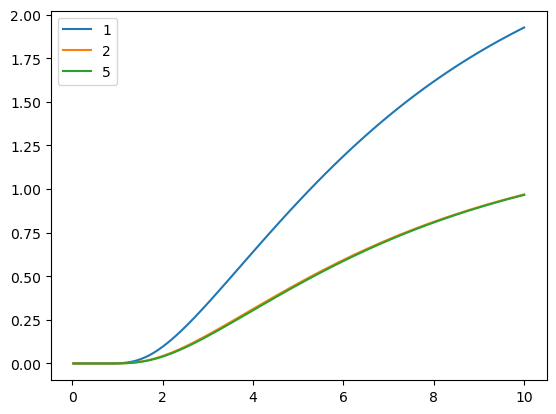

(-0.09630549851930777, 2.022415468905463)

In [278]:
for i in [1,2,5]
    Ts = kmap_T_dependence[i][1,:]
    Sqs = kmap_T_dependence[i][2,:]
    χs = Sqs ./ Ts
    PyPlot.plot(Ts, 1.0 ./ χs, "-", label="$i")
end
PyPlot.legend()
PyPlot.ylim()

In [ ]:
k1 = hcat([[T, V[1]] for (T, V) in results]...)


In [232]:
select_temperatures = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0];

In [233]:
select_indices = [findfirst(==(y), temperatures) for y in select_temperatures]

8-element Vector{Int64}:
   5
  10
  11
  14
  19
  29
  59
 109

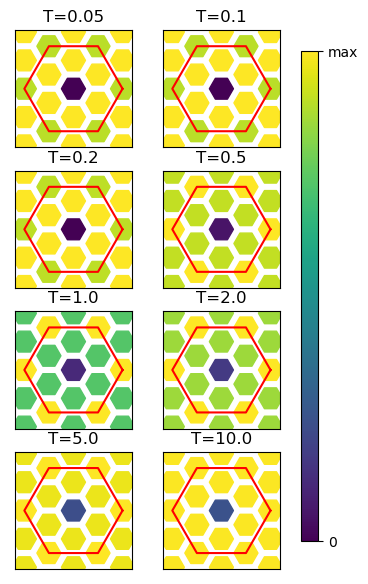

2-element Vector{PyObject}:
 PyObject Text(1, 0, '0')
 PyObject Text(1, 1, 'max')

In [234]:
fig = PyPlot.figure(figsize=(3.5, 7))
maxval = 0.0
ax = nothing
img = nothing


for i in 1:8
    j = select_indices[i]
    T, Sq = results[j]
    ax = fig.add_subplot(4,2,i)
    k0 = momentums .* 2π
    G = reciprocallatticevectors
    v0 = abs2.(Sq)
    k = Matrix{Float64}(undef, (2,0))
    v = Vector{Float64}(undef, 0)
    for R1 in [-1,0,1], R2 in [-1,0,1]
        R = [R1;R2]
        k = hcat(k, broadcast(+, k0, G * R))
        v = vcat(v, v0)
    end
    img = ax.scatter(k[1,:], k[2,:], s=300, c=mpl.cm.viridis(v ./ maximum(v)), marker="H")
    ax.plot(zone_boundary[1,:], zone_boundary[2,:], color="red")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_aspect(1.0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("T=$(T)")
end
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
# cbar_ax.set_yticks([0, 1])
cbar_ax.set_yticklabels(["0", "max"])

In [125]:
reciprocallattice = hcat((reciprocallatticevectors * [R1, R2]  for R1 in [-1,0,1] for R2 in [-1,0,1])...)

2×9 Matrix{Float64}:
  -6.28319  -6.28319  -6.28319  …  0.0      6.28319  6.28319   6.28319
 -10.8828   -3.6276    3.6276      7.2552  -3.6276   3.6276   10.8828

In [128]:
sp = pyimport("scipy")
pyimport("scipy.spatial")

PyObject <module 'scipy.spatial' from '/gpfs/home/kyungminlee_42/.pyenv/versions/conda_jl/lib/python3.7/site-packages/scipy/spatial/__init__.py'>

In [133]:
voro = sp.spatial.Voronoi(reciprocallattice')

PyObject <scipy.spatial.qhull.Voronoi object at 0x2b5ad6fd9750>

In [151]:
p0 = [4π/3, 0]
R = [cos(π/3) -sin(π/3); sin(π/3) cos(π/3)]
zone_boundary = [p0]
p = p0
for i in 1:5
    p = R * p
    push!(zone_boundary, p)
end
push!(zone_boundary, p0)
zone_boundary = hcat(zone_boundary...)

2×7 Matrix{Float64}:
 4.18879  2.0944  -2.0944  -4.18879      -2.0944   2.0944  4.18879
 0.0      3.6276   3.6276   1.51297e-15  -3.6276  -3.6276  0.0

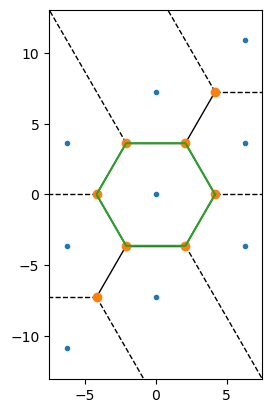

In [152]:

sp.spatial.voronoi_plot_2d(voro)
ax = PyPlot.gca()
# ax.plot([0,4π/3], [0,0])
ax.set_aspect(1.0)

In [137]:
voro.regions

10-element Vector{Vector}:
 Any[]
 [1, 0, -1]
 [4, -1, 2, 3]
 [4, -1]
 [4, -1, 0, 3]
 [7, -1, 5, 6]
 [-1, 2, 5]
 [6, 1, 0, 3, 2, 5]
 [7, -1]
 [7, -1, 1, 6]

In [138]:
voro.ridge_points

16×2 Matrix{Int32}:
 6  3
 6  4
 6  7
 1  2
 1  4
 1  0
 1  3
 0  3
 3  4
 5  2
 5  4
 5  8
 5  7
 2  4
 4  7
 8  7

In [140]:
voro.vertices

8×2 Matrix{Float64}:
  2.0944   -3.6276
  4.18879   0.0
 -4.18879   0.0
 -2.0944   -3.6276
 -4.18879  -7.2552
 -2.0944    3.6276
  2.0944    3.6276
  4.18879   7.2552